# NYC Bike-Sharing Data Analysis

### Objective
Bike sharing has become an integral part of New York City’s transportation network. Every month, thousands of rides take place, generating a wealth of information about rider behavior. This notebook analysis a given month of bike-sharing data from [Citi Bike](https://citibikenyc.com/system-data) to answer the quetion: 

> **Does it make sense to introduce an insurance fee for rides that last more than 30 minutes?**

---

### Key Questions
Main Questions to answer:

1. **How many rides exceed 30 minutes?**  
2. **What revenue could be generated if we charge USD 0.20 for each ride over 30 minutes?**  
3. **How far do people typically travel, categorized into distance buckets (0–1, 2–4, 4–9, and 10+)?**

---

### Structure of the Notebook

1. **Environment Setup**  
   - Import necessary libraries and set up PySpark 
   - Load the NYC bike-sharing dataset<br><br>
  

2. **Data Quality Review**  
   - Assess the completeness and accuracy of the data
   - Get first look into the data
   - Confirm that the dataset is sufficient for our analysis goals<br><br>

3. **Core Calculations**  
   - Compute ride distances 
   - Identify rides longer than 30 minutes and estimate potential insurance revenue<br><br>

4. **Visualizations**  
   - Presenting key findings in clear and concise charts (e.g., bar charts, histograms)  
   - Highlight distance distributions and long-ride frequencies<br><br>

5. **Reporting**  
   - Summarize critical insights in a tailored report (Bottom of the Notebook)
   - Outline actionable recommendations for introducing an insurance fee


---



# 1. Environment Setup


In [1]:
import nbimporter
import get_raw_data
import os
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from jinja2 import Template
from pyspark.sql import SparkSession, functions as F, types as T
import folium
import matplotlib as mpl
from folium.plugins import HeatMap
import sys
from io import StringIO
import seaborn as sns 
from pyspark.ml.feature import Bucketizer


# options to dispaly dfs 
pd.options.display.float_format = '{:,.0f}'.format  # Adjust number format if needed
pd.set_option("display.colheader_justify", "center")  # Center column headers

# Configure logging explicitly for Jupyter Notebook
logger = logging.getLogger()  # Get the root logger
if not logger.hasHandlers():  # Avoid adding multiple handlers in Jupyter Notebook
    handler = logging.StreamHandler()  # Log to the notebook output cell
    formatter = logging.Formatter("%(asctime)s - %(levelname)s - %(message)s")
    handler.setFormatter(formatter)
    logger.addHandler(handler)
logger.setLevel(logging.INFO)

# Set JAVA_HOME and update PATH
#os.environ['JAVA_HOME'] = r'C:\Users\USER\AppData\Local\Programs\Eclipse Adoptium\jdk-11.0.26.4-hotspot'
#os.environ['PATH'] = os.environ['JAVA_HOME'] + r'\bin;' + os.environ['PATH']

#print("JAVA_HOME:", os.environ.get('JAVA_HOME'))

# Start PySpark session
spark = SparkSession.builder \
    .appName("NYC Bike Sharing Analysis") \
    .getOrCreate()


JAVA_HOME: C:\Users\de128574\AppData\Local\Programs\Eclipse Adoptium\jdk-11.0.26.4-hotspot


In [2]:
BASE_URL =  "https://s3.amazonaws.com/tripdata/index.html"  # Replace with the actual base URL
RAW_FOLDER = "01raw"                  # Folder to store raw ZIP files and extracted CSVs
EXTRACT_SUBFOLDER = "csv_files"       # Subfolder for extracted CSV files
CLEANED_FOLDER = "02cleansed"         # Folder to store the final Parquet file
PARQUET_FILE = "cleaned_data.parquet" # Name of the cleansed Parquet file
TIMESTAMP = "202412"                  # Use "latest" or a specific timestamp like "202006"


# fetches one month of bike sharing data and provides parqeuts file
# function defined in get_raw_data notebook
result = get_raw_data.get_newest_data(
    base_url=BASE_URL,
    raw_folder=RAW_FOLDER,
    extract_subfolder=EXTRACT_SUBFOLDER,
    cleaned_folder=CLEANED_FOLDER,
    parquet_file=PARQUET_FILE,
    timestamp=TIMESTAMP,
    force_download=False # Set to true for forcing download
)


if result:
    logging.info(f"Process complete. Parquet file available at: {result}")
else:
    logging.error("Process failed.")


2025-02-09 19:47:23,039 - INFO - Fetching ZIP file links...
2025-02-09 19:47:23,043 - INFO - ====== WebDriver manager ======
2025-02-09 19:47:25,187 - INFO - Get LATEST chromedriver version for google-chrome
2025-02-09 19:47:25,959 - INFO - Get LATEST chromedriver version for google-chrome
2025-02-09 19:47:26,671 - INFO - Driver [C:\Users\de128574\.wdm\drivers\chromedriver\win64\132.0.6834.159\chromedriver-win32/chromedriver.exe] found in cache
2025-02-09 19:47:34,483 - INFO - Target ZIP file: 202412-citibike-tripdata.zip
2025-02-09 19:47:34,485 - INFO - Clearing raw and cleansed folders for new data download...
2025-02-09 19:48:47,318 - INFO - Downloaded: 01raw\202412-citibike-tripdata.zip
2025-02-09 19:48:48,033 - INFO - Extracted 01raw\202412-citibike-tripdata.zip to 01raw\csv_files
2025-02-09 19:48:48,036 - INFO - Converting 01raw\csv_files\202412-citibike-tripdata_1.csv to Parquet...
2025-02-09 19:48:58,053 - INFO - Loaded CSV file: 01raw\csv_files\202412-citibike-tripdata_1.csv
2

---

## 1. Data Quality Review

This section, verifys that the data is accurate and complete enough to support meaningful analysis. By catching issues early such as invalid timestamps, missing station details, or duplicate ID

- **Convert timestamps:** Transform the `started_at` and `ended_at` fields into proper timestamp formats.
- **Compute ride durations:** Calculate the duration of each ride in seconds and minutes.
- **Validate station information:** Identify missing station names that could affect route analysis.
- **Check coordinate validity:** Ensure that the latitude and longitude values are within valid ranges.
- **Detect duplicates:** Identify any duplicate ride IDs that might indicate data quality issues.



In [3]:
# Read data into df
df = spark.read.parquet(CLEANED_FOLDER + "/" + PARQUET_FILE)
print("Initial Schema:")
df.printSchema()

Initial Schema:
root
 |-- ride_id: double (nullable = true)
 |-- rideable_type: string (nullable = true)
 |-- started_at: string (nullable = true)
 |-- ended_at: string (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_station_id: double (nullable = true)
 |-- end_station_name: string (nullable = true)
 |-- end_station_id: double (nullable = true)
 |-- start_lat: string (nullable = true)
 |-- start_lng: string (nullable = true)
 |-- end_lat: string (nullable = true)
 |-- end_lng: string (nullable = true)
 |-- member_casual: string (nullable = true)



In [4]:
# Only necessary for Report in the end

# Capture schema as a formatted string
buffer = StringIO()
original_stdout = sys.stdout  # Save the original stdout

try:
    sys.stdout = buffer  
    df.printSchema()  
finally:
    sys.stdout = original_stdout  

# Process the captured schema
schema_str = buffer.getvalue() 
schema_html = schema_str.replace("\n", "<br>")
 



 ### 1.1 Timestamp Conversion and Validation

 Convert the `started_at` and `ended_at` columns to timestamp types. Then, check for rows where conversion fails.


In [5]:
df = df.withColumn("started_at_ts", F.to_timestamp("started_at")) \
       .withColumn("ended_at_ts", F.to_timestamp("ended_at"))

# Identify rows with invalid timestamps
invalid_ts_df = df.filter(F.col("started_at_ts").isNull() | F.col("ended_at_ts").isNull())
invalid_ts_count = invalid_ts_df.count()
print(f"Rows with invalid timestamps: {invalid_ts_count}")

Rows with invalid timestamps: 0


 ### 1.2 Ride Duration Calculation and Anomaly Detection

 Compute ride duration in seconds and minutes. Flag rides with non-positive (zero or negative) durations.


In [6]:
df = df.withColumn("duration_sec", 
                   F.unix_timestamp("ended_at_ts") - F.unix_timestamp("started_at_ts")) \
       .withColumn("duration_min", F.col("duration_sec") / 60)

# Find rides with non-positive durations
invalid_duration_df = df.filter(F.col("duration_min") <= 0)
invalid_duration_count = invalid_duration_df.count()
print(f"Rows with non-positive ride durations (<= 0 minutes): {invalid_duration_count}")

# Show summary statistics for ride duration
print("Ride Duration (minutes) Summary:")
df.select("duration_min").describe().show()

Rows with non-positive ride durations (<= 0 minutes): 0
Ride Duration (minutes) Summary:
+-------+------------------+
|summary|      duration_min|
+-------+------------------+
|  count|           1000000|
|   mean|10.568523449999255|
| stddev| 26.91107922348566|
|    min|1.0166666666666666|
|    max|1499.9666666666667|
+-------+------------------+



 ### 1.3 Station Information Validation
 Check for missing start or end station names which could affect route and popularity analyses.


In [7]:
missing_station_df = df.filter(F.col("start_station_name").isNull() | F.col("end_station_name").isNull())
missing_station_count = missing_station_df.count()
print(f"Rows with missing station names: {missing_station_count}")

Rows with missing station names: 3957


 ### 1.4 Coordinate Conversion and Validation

 Convert the coordinate columns to `double` and ensure that latitude values lie between -90 and 90 and longitude values between -180 and 180.


In [8]:
coordinate_cols = ["start_lat", "start_lng", "end_lat", "end_lng"]
for col in coordinate_cols:
    df = df.withColumn(col, F.col(col).cast("double"))

invalid_coords_df = df.filter(
    (F.col("start_lat").isNull()) | (F.col("start_lng").isNull()) |
    (F.col("end_lat").isNull())   | (F.col("end_lng").isNull())   |
    (F.col("start_lat") < -90) | (F.col("start_lat") > 90) |
    (F.col("end_lat") < -90)   | (F.col("end_lat") > 90)   |
    (F.col("start_lng") < -180) | (F.col("start_lng") > 180) |
    (F.col("end_lng") < -180)   | (F.col("end_lng") > 180)
)
invalid_coords_count = invalid_coords_df.count()
print(f"Rows with invalid or missing coordinate values: {invalid_coords_count}")

Rows with invalid or missing coordinate values: 205


 ### 1.5 Duplicate Ride ID Detection

 Identify duplicate ride IDs to ensure data integrity.

In [9]:
duplicate_ids_df = df.groupBy("ride_id").count().filter(F.col("count") > 1)
duplicate_ids_count = duplicate_ids_df.count()
print(f"Number of duplicate ride_id entries: {duplicate_ids_count}")

Number of duplicate ride_id entries: 2


 ### 1.6 Data Quality Summary

 Summarize the quality issues to understand potential impacts on our analysis.

In [10]:
total_rows = df.count()
quality_summary = {
    "Total_Rows": total_rows,
    "Invalid_Timestamps": invalid_ts_count,
    "Non_Positive_Durations": invalid_duration_count,
    "Missing_Station_Names": missing_station_count,
    "Invalid_Coordinates": invalid_coords_count,
    "Duplicate_Ride_IDs": duplicate_ids_count
}

quality_summary_df = pd.DataFrame([quality_summary])
print("Data Quality Summary:")
display(quality_summary_df)

Data Quality Summary:


,Total_Rows,Invalid_Timestamps,Non_Positive_Durations,Missing_Station_Names,Invalid_Coordinates,Duplicate_Ride_IDs
0,1000000,0,0,3957,205,2


### Key Observations

- **Successful Timestamp Conversion**  
  All timestamps were transformed without errors, making time-based computations straightforward.

- **No Zero-Duration Rides**  
  No entries had a non-positive ride duration, indicating minimal data entry errors and a generally healthy dataset.

- **Minor Data Gaps**  
  A small percentage of rows contained missing station names or invalid coordinate values. These can be flagged or excluded to preserve the integrity of subsequent analyses.

- **Few Duplicate IDs**  
  Only a handful of duplicate ride IDs appeared. After addressing these cases, the dataset is largely free from duplication.

Overall, these checks confirm our data is sufficiently robust for the upcoming analysis.

---

## 2. Core Calculations

The primary goal here is to evaluate whether introducing an insurance product for rides longer than 30 minutes makes business sense. We focus on three key questions:

1. **Coverage**  
   How many rides exceed 30 minutes?

2. **Revenue**  
   If we charge \$0.20 for each eligible ride, how much additional revenue could this generate?

3. **Distance Distribution**  
   How do rides break down across different travel distance categories (0–1, 2–4, 4–9, and 10+ miles)?

### Methodology

- **Ride Duration**  
  We converted the `started_at` and `ended_at` columns to timestamps and computed each ride’s duration in minutes. Any ride over 30 minutes was labeled as eligible for the proposed insurance fee.
  
- **Distance Calculation**  
  Using the Haversine formula, we calculated the distance for each trip based on the start and end coordinates. We then grouped these distances into four buckets:  
  - **0–1 miles**  
  - **2–4 miles**  
  - **4–9 miles**  
  - **10+ miles**

These foundational calculations allow us to assess how many rides could be covered, estimate potential revenue, and understand typical travel ranges.


 ### 2.1 Insurance Coverage and Revenue Analysis

 Identify rides longer than 30 minutes and calculate the expected insurance revenue.


In [11]:
insured_trips_df = df.filter(F.col("duration_min") > 30)
insured_count = insured_trips_df.count()

insurance_charge = 0.20  # USD per qualifying ride
expected_revenue = insured_count * insurance_charge

print(f"Number of rides lasting > 30 minutes: {insured_count}")
print(f"Expected insurance revenue (@ ${insurance_charge:.2f} per ride): ${expected_revenue:.2f}")


Number of rides lasting > 30 minutes: 33104
Expected insurance revenue (@ $0.20 per ride): $6620.80


 ### 2.2 Distance Calculation and Bucketization

 We calculate the ride distance using the Haversine formula. Then, we assign each ride into one of the following buckets:

 - **"0-1"**: distance ≤ 1 mile
 - **"2-4"**: 1 < distance ≤ 4 miles
 - **"4-9"**: 4 < distance ≤ 9 miles
 - **"10+"**: distance > 9 miles

In [12]:
R = 3959.0  # Earth's radius in miles

# Calculate differences in radians
df = df.withColumn("delta_lat", F.radians(F.col("end_lat") - F.col("start_lat"))) \
       .withColumn("delta_lng", F.radians(F.col("end_lng") - F.col("start_lng"))) \
       .withColumn("start_lat_rad", F.radians(F.col("start_lat"))) \
       .withColumn("end_lat_rad", F.radians(F.col("end_lat")))

# Apply the Haversine formula
df = df.withColumn("a", F.pow(F.sin(F.col("delta_lat") / 2), 2) +
                   F.cos(F.col("start_lat_rad")) * F.cos(F.col("end_lat_rad")) *
                   F.pow(F.sin(F.col("delta_lng") / 2), 2)) \
       .withColumn("c", 2 * F.asin(F.sqrt(F.col("a")))) \
       .withColumn("distance", F.lit(R) * F.col("c"))

# Bucket the distances
df = df.withColumn("distance_bucket", 
                   F.when(F.col("distance") <= 1, "0-1")
                    .when((F.col("distance") > 1) & (F.col("distance") <= 4), "2-4")
                    .when((F.col("distance") > 4) & (F.col("distance") <= 9), "4-9")
                    .otherwise("10+")
                  )

# Aggregate ride counts per distance bucket and convert to Pandas for visualization
buckets_df = df.groupBy("distance_bucket").count().orderBy("distance_bucket")
buckets_pdf = buckets_df.toPandas()
print("Distance Bucket Distribution:")
display(buckets_pdf)

Distance Bucket Distribution:


,distance_bucket,count
0,0-1,593723
1,10+,371
2,2-4,387713
3,4-9,18193


### Observations
- **Coverage**  
  A total of **33,104 rides** exceeded 30 minutes.

- **Revenue**  
  At a rate of \$0.20 for each ride over 30 minutes, the projected **additional revenue** is **\$6,620.80**.

- **Distance Distribution**  
  - **0–1 miles:** 593,723 rides  
  - **2–4 miles:** 387,713 rides  
  - **4–9 miles:** 18,193 rides  
  - **10+ miles:** 371 rides  

Collectively, these figures provide a clear picture of both the scale and the potential financial opportunity of an insurance offering.

---

## 3. Visualizations

For the understanding of the data and confirm the insights from our calculations, we’ve generated a series of visualizations. These charts visualize the fidnigns reagind the analysis, although some report are created for a better understanding and overveiw of the data, a clear distinction is made in the final rpeort:

- **Ride Duration Distribution by Membership**  
  A histogram comparing ride durations for members versus casual riders. This helps identify differences in typical ride lengths across user groups.

- **Hourly Ride Counts**  
  A line chart displaying the number of rides across each hour of the day. It reveals peak usage times and provides a sense of when demand for the service is highest.

- **Distance Bucket Distribution**  
  A bar chart illustrating how many rides fall into each distance bucket (0–1, 2–4, 4–9, and 10+ miles). This visualization makes it clear where most users’ trips cluster in terms of total distance traveled.




In [13]:
colors = {
    "primary": "#FF7900",     # A strong orange
    "secondary": "#FFB84D",   # A lighter orange
    "tertiary": "#FFCC99",    # Even lighter orange
    "quaternary": "#FFDAB3"   # A very light orange
}

sns.set_theme(style="whitegrid", palette=[colors["primary"], colors["secondary"], colors["tertiary"], colors["quaternary"]])
mpl.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 18,
    'axes.titleweight': 'bold',
    'axes.labelsize': 14,
    'figure.figsize': (8, 6),
})

In [14]:
def save_figure(fig, filename, dpi=300):
    folder = "03results"
    if not os.path.exists(folder):
        os.makedirs(folder)
        print(f"Created folder: {folder}")
    
    # Save the figure to the specified file
    fig.savefig(f"{folder}/{filename}", dpi=dpi, format="png", bbox_inches="tight")
    print(f"Saved: {folder}/{filename}")
    
def style_axes(ax, title, xlabel, ylabel):
    """Apply consistent styling to axes."""
    ax.set_title(title, fontsize=18, weight="bold", color="#2c3e50", pad=10)
    ax.set_xlabel(xlabel, fontsize=14, labelpad=10)
    ax.set_ylabel(ylabel, fontsize=14, labelpad=10)
    ax.tick_params(axis="x", labelsize=12)
    ax.tick_params(axis="y", labelsize=12)
    ax.grid(axis="y", linestyle="--", alpha=0.7)
    


### Figure 1: Ride Duration Distribution by Membership
histogram of ride durations broken down by membership type (e.g., "member" versus "casual").
helps us understand how ride durations differ between user groups and identifies which group is more likely to have longer rides—information that is critical for assessing the potential market for the insurance product.

Saved: 03results/ride_duration_distribution.png


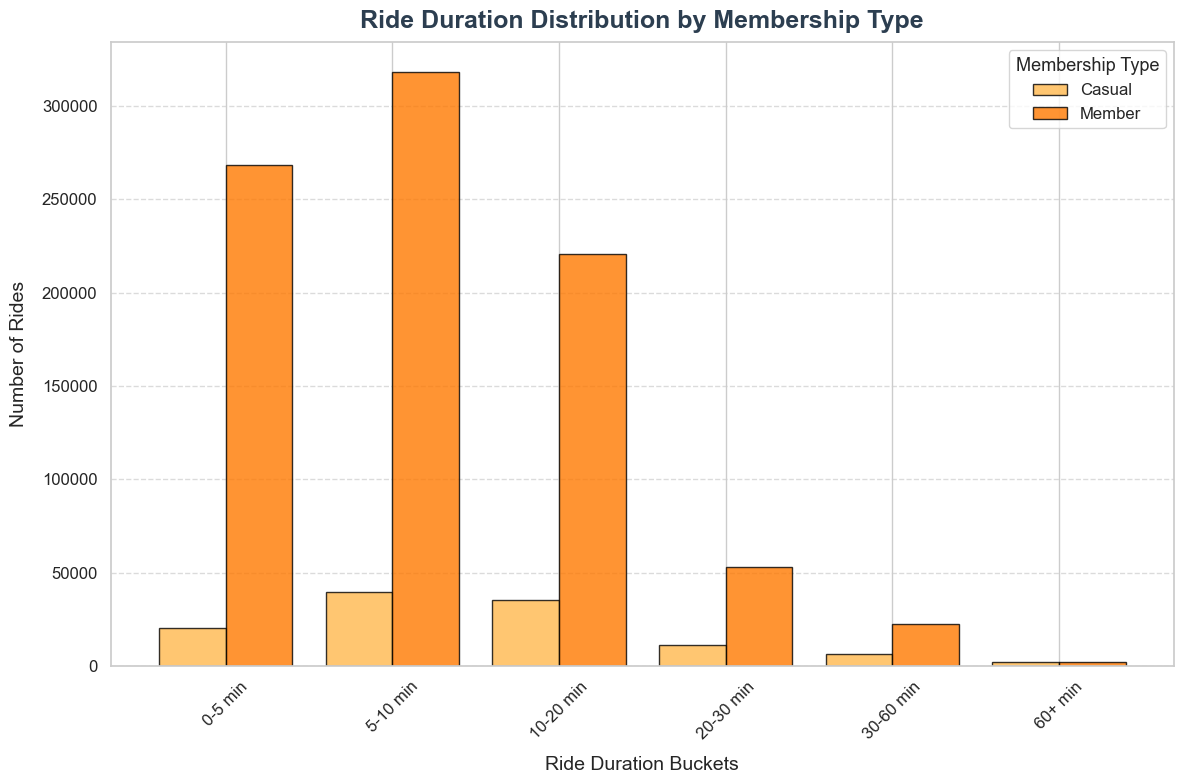

In [15]:
def plot_ride_duration_distribution(hist_pdf, bucket_order):
    fig, ax = plt.subplots(figsize=(12, 8))
    width = 0.4  # Bar width
    membership_types = hist_pdf["member_casual"].unique()
    
    # Assign a color to each membership type consistently
    color_map = {
        membership_types[0]: colors["secondary"],
        membership_types[1]: colors["primary"]
    }
    
    for i, mtype in enumerate(membership_types):
        subset = hist_pdf[hist_pdf["member_casual"] == mtype]
        # Determine x positions based on the bucket order indices
        x_positions = [bucket_order.index(bin_label) for bin_label in subset["duration_bin"]]
        offset = width * (i - 0.5)
        ax.bar(
            [pos + offset for pos in x_positions],
            subset["count"],
            width=width,
            alpha=0.8,
            label=mtype.capitalize(),
            edgecolor="black",
            color=color_map[mtype]
        )
    
    ax.set_xticks(range(len(bucket_order)))
    ax.set_xticklabels(bucket_order, rotation=45, fontsize=12)
    style_axes(ax, "Ride Duration Distribution by Membership Type", "Ride Duration Buckets", "Number of Rides")
    ax.legend(title="Membership Type", title_fontsize=13, fontsize=12, loc="upper right", frameon=True)
    plt.tight_layout()
    return fig


#Define the bucket boundaries for duration in minutes
splits = [0, 5, 10, 20, 30, 60, float("inf")]
bucketizer = Bucketizer(splits=splits, inputCol="duration_min", outputCol="duration_bin_numeric")
df_binned = bucketizer.transform(df.select("member_casual", "duration_min"))

#  Group by membership type and numeric bucket, then count rides in each group
hist_df = df_binned.groupBy("member_casual", "duration_bin_numeric").count().orderBy("member_casual", "duration_bin_numeric")
hist_pdf = hist_df.toPandas()

# Bucket labels
bucket_order = ["0-5 min", "5-10 min", "10-20 min", "20-30 min", "30-60 min", "60+ min"]

# 6. Map the numeric bucket index to the corresponding label
bucket_map = {i: label for i, label in enumerate(bucket_order)}
hist_pdf["duration_bin"] = hist_pdf["duration_bin_numeric"].map(bucket_map)

fig1 = plot_ride_duration_distribution(hist_pdf, bucket_order)
save_figure(fig1, "ride_duration_distribution.png")

### Figure 2: Hourly Ride Counts
This line chart displays the number of rides initiated during each hour of the day.
It reveals temporal patterns in ride demand, highlighting the peak usage hours.

Saved: 03results/hourly_ride_counts.png


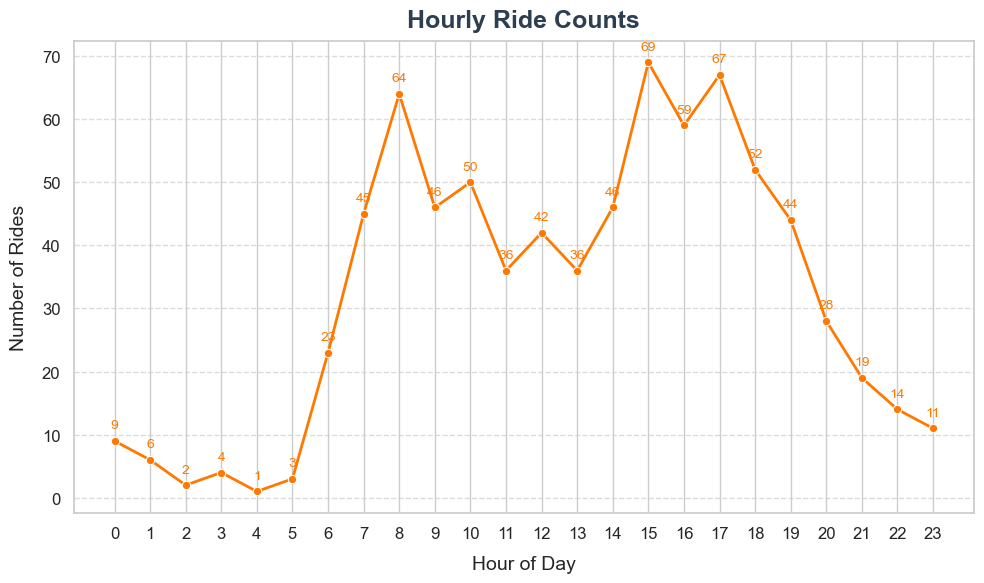

In [16]:
def plot_hourly_ride_counts(hourly_rides_pdf):
    """
    Plot hourly ride counts using a line plot with data labels.
    
    Parameters:
      - hourly_rides_pdf: Pandas DataFrame with columns "start_hour" and "ride_count".
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    # Use the primary color from our global palette
    sns.lineplot(x=hourly_rides_pdf["start_hour"],
                 y=hourly_rides_pdf["ride_count"],
                 marker="o", color=colors["primary"], linewidth=2, ax=ax)
    
    # Add text labels for each data point using the same primary color
    for x, y in zip(hourly_rides_pdf["start_hour"], hourly_rides_pdf["ride_count"]):
        ax.text(x, y + 2, f"{y}", color=colors["primary"], ha="center", fontsize=10)
    
    style_axes(ax, "Hourly Ride Counts", "Hour of Day", "Number of Rides")
    ax.set_xticks(hourly_rides_pdf["start_hour"])
    ax.set_xticklabels(hourly_rides_pdf["start_hour"], fontsize=12)
    plt.tight_layout()
    return fig


# --- Fast Figure 2: Hourly Ride Counts ---
hourly_rides_df = (
    df.withColumn("start_hour", F.hour("started_at_ts"))
      .groupBy("start_hour")
      .agg(F.count("ride_id").alias("ride_count"))
      .orderBy("start_hour")
)
# Convert the small aggregated DataFrame to Pandas
hourly_rides_pdf = hourly_rides_df.toPandas()


fig2 = plot_hourly_ride_counts(hourly_rides_pdf)
save_figure(fig2, "hourly_ride_counts.png")


### Figure 3: Distance Bucket Distribution
The bar chart shows the distribution of rides across predefined travel distance buckets (0-1, 2-4, 4-9, and 10+ miles).
This diagram provides insight into customer travel behavior by illustrating which distance ranges are most common among riders.
Knowing that the majority of rides are short (0-1 mile) while a meaningful portion falls into longer categories helps us consider if differentiated insurance pricing or coverage options are warranted.

Saved: 03results/distance_bucket_distribution.png


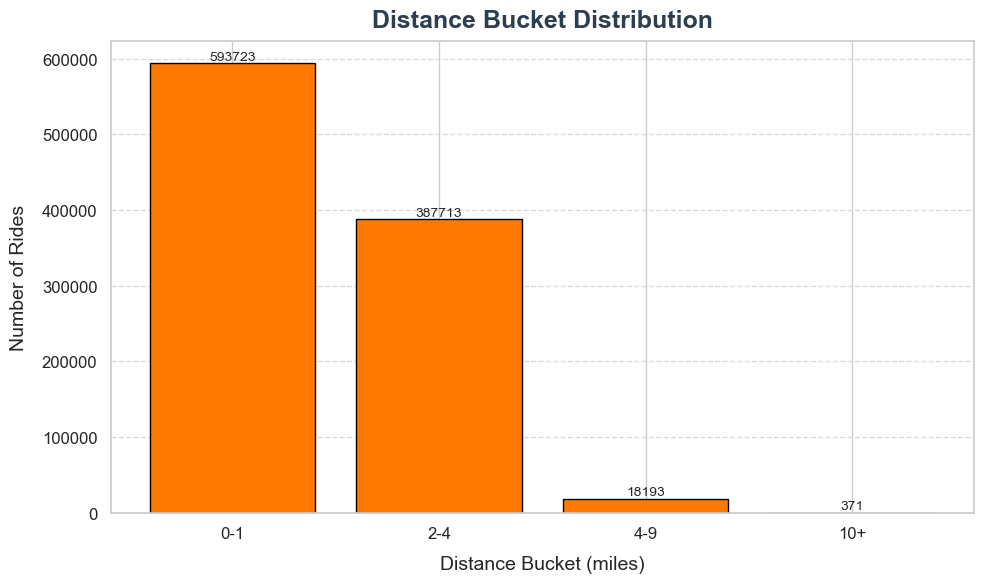

In [17]:
def plot_distance_bucket_distribution(buckets_pdf):
    """
    Plot a bar chart for distance bucket distribution.
    
    Parameters:
      - buckets_pdf: Pandas DataFrame with columns "distance_bucket" and "count".
    """
    buckets_pdf = buckets_pdf.iloc[::-1]
    fig, ax = plt.subplots(figsize=(10, 6))
    # Use the primary color for bars from our global palette
    bars = ax.bar(buckets_pdf["distance_bucket"], buckets_pdf["count"],
                  color=colors["primary"], edgecolor="black")
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 1000,
                f"{int(height)}", ha="center", va="bottom", fontsize=10)
    
    style_axes(ax, "Distance Bucket Distribution",
               "Distance Bucket (miles)", "Number of Rides")
    plt.tight_layout()
    return fig

buckets_pdf = (
    df.groupBy("distance_bucket")
      .count()
      .toPandas()
)
# 3. Distance Bucket Distribution (Bar Chart)
fig3 = plot_distance_bucket_distribution(buckets_pdf)
save_figure(fig3, "distance_bucket_distribution.png")


### Additional Diagrams
Percentage of Rides > 30 Minutes:
A pie chart was created to show the share of rides lasting more than 30 minutes relative to all rides. This diagram quantifies the target market size for the insurance offering.

Distance Bucket Distribution (Percentage):
Another pie chart illustrates the percentage distribution of rides among the travel distance buckets. This helps us understand the relative prevalence of each travel distance segment, which is useful for tailoring insurance coverage options.

Saved: 03results/percentage_rides_over30.png


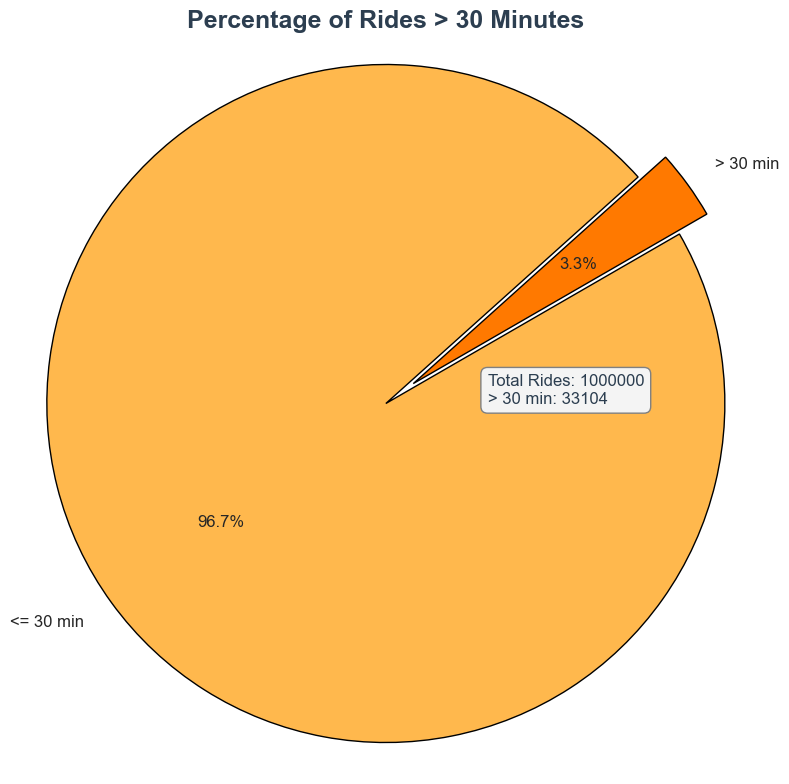

In [18]:
def plot_percentage_rides_over30(total_rides, over30_count):
    percentage_over30 = (over30_count / total_rides) * 100
    percentage_le30 = 100 - percentage_over30
    labels = ["> 30 min", "<= 30 min"]
    sizes = [percentage_over30, percentage_le30]
    # Use your primary and secondary colors for consistency
    pie_colors = [colors["primary"], colors["secondary"]]
    explode = (0.1, 0)
    
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.pie(
        sizes, 
        labels=labels, 
        autopct="%1.1f%%", 
        startangle=30, 
        colors=pie_colors, 
        explode=explode, 
        textprops={"fontsize": 12}, 
        wedgeprops={"edgecolor": "black"}
    )
    ax.set_title("Percentage of Rides > 30 Minutes", fontsize=18, weight="bold", color="#2c3e50", pad=0)
    
    total_rides_annotation = f"Total Rides: {total_rides}\n> 30 min: {over30_count}"
    ax.text(
        0.3, 0, total_rides_annotation, fontsize=12, color="#2c3e50",
        bbox=dict(boxstyle="round,pad=0.4", edgecolor="gray", facecolor="#f4f4f4", alpha=1)
    )
    ax.axis("equal")
    plt.tight_layout()
    return fig


# 4. Percentage of Rides > 30 Minutes (Pie Chart)
# Compute total rides and rides over 30 minutes using Spark
total_rides = df.count()
over30_count = df.filter(F.col("duration_min") > 30).count()

fig4 = plot_percentage_rides_over30(total_rides, over30_count)
save_figure(fig4, "percentage_rides_over30.png")

Saved: 03results/distance_bucket_percentage.png


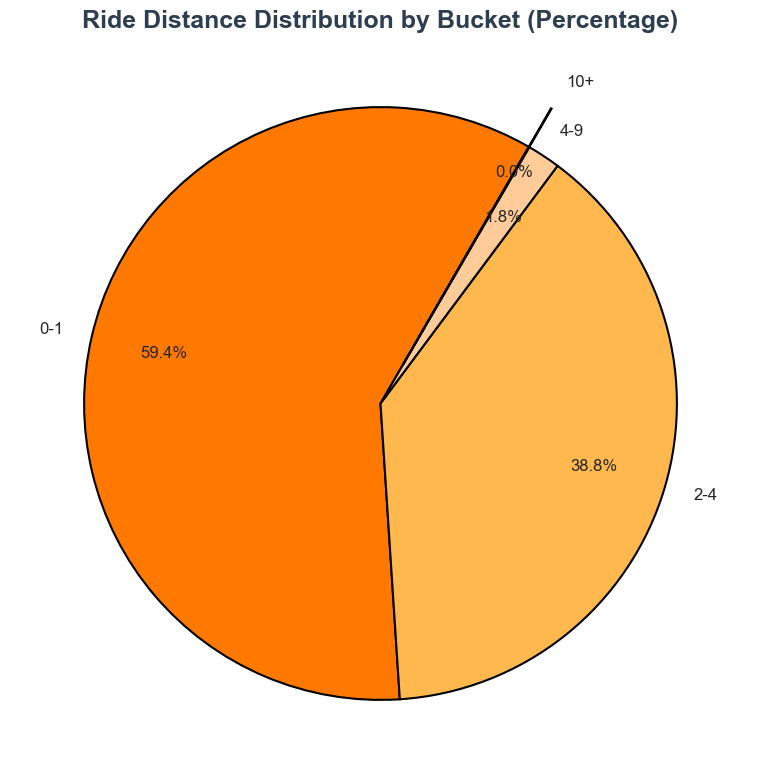

In [19]:
def plot_distance_bucket_percentage(buckets_pdf, desired_order):
    """
    Plot a pie chart for ride distance distribution by bucket (percentage).
    
    Parameters:
      - buckets_pdf: Pandas DataFrame with columns "distance_bucket" and "count".
      - desired_order: List of bucket labels in the desired order.
    """
    total_bucket_count = buckets_pdf["count"].sum()
    buckets_pdf["percentage"] = buckets_pdf["count"] / total_bucket_count * 100
    buckets_pdf["distance_bucket"] = pd.Categorical(
        buckets_pdf["distance_bucket"], categories=desired_order, ordered=True)
    buckets_pdf = buckets_pdf.sort_values("distance_bucket")
    
    labels = buckets_pdf["distance_bucket"].tolist()
    sizes = buckets_pdf["percentage"].tolist()
    # Use the global palette for a consistent look
    colors_list = [colors["primary"], colors["secondary"],
                   colors["tertiary"], colors["quaternary"]]
    # Explode the "10+" slice for emphasis (if it exists)
    explode = [0.15 if lbl == "10+" else 0 for lbl in labels]
    
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.pie(sizes, labels=labels, autopct="%1.1f%%",
           startangle=60, colors=colors_list, explode=explode,
           textprops={"fontsize": 12},
           wedgeprops={"edgecolor": "black", "linewidth": 1.5},
           pctdistance=0.75)
    ax.set_title("Ride Distance Distribution by Bucket (Percentage)",
                 fontsize=18, weight="bold", color="#2c3e50", pad=0)
    plt.tight_layout()
    return fig



buckets_pdf = (
    df.groupBy("distance_bucket")
      .count()
      .toPandas()
)
desired_order = ["0-1", "2-4", "4-9", "10+"]
fig5 = plot_distance_bucket_percentage(buckets_pdf, desired_order)
save_figure(fig5, "distance_bucket_percentage.png")

### Interactive Station Map

 interactive map that visualizes:

 - **Start Stations:** Blue circle markers sized by usage  
 - **End Stations:** Red circle markers sized by usage  
 - **HeatMap:** A combined heatmap of station usage

In [20]:

# Aggregate Start Station Usage
start_station_usage = df.groupBy("start_station_name", "start_lat", "start_lng") \
    .agg(F.count("ride_id").alias("start_count"))
start_usage_pdf = start_station_usage.toPandas().dropna(subset=['start_lat', 'start_lng'])

# Aggregate End Station Usage
end_station_usage = df.groupBy("end_station_name", "end_lat", "end_lng") \
    .agg(F.count("ride_id").alias("end_count"))
end_usage_pdf = end_station_usage.toPandas().dropna(subset=['end_lat', 'end_lng'])

# Create base map centered on NYC
nyc_map = folium.Map(location=[40.7128, -74.0060], zoom_start=12)

# Feature Group for Start Stations
start_fg = folium.FeatureGroup(name="Start Stations")
def get_radius(count, base=3):
    return base + np.sqrt(count)
for idx, row in start_usage_pdf.iterrows():
    radius = get_radius(row["start_count"])
    popup_text = (f"<strong>{row['start_station_name']}</strong><br>"
                  f"Start Count: {row['start_count']}")
    folium.CircleMarker(
        location=[row["start_lat"], row["start_lng"]],
        radius=radius,
        popup=popup_text,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(start_fg)
nyc_map.add_child(start_fg)

# Feature Group for End Stations
end_fg = folium.FeatureGroup(name="End Stations")
for idx, row in end_usage_pdf.iterrows():
    radius = get_radius(row["end_count"])
    popup_text = (f"<strong>{row['end_station_name']}</strong><br>"
                  f"End Count: {row['end_count']}")
    folium.CircleMarker(
        location=[row["end_lat"], row["end_lng"]],
        radius=radius,
        popup=popup_text,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.6
    ).add_to(end_fg)
nyc_map.add_child(end_fg)

# Combined HeatMap Layer
heat_data = []
for idx, row in start_usage_pdf.iterrows():
    heat_data.append([row["start_lat"], row["start_lng"], row["start_count"]])
for idx, row in end_usage_pdf.iterrows():
    heat_data.append([row["end_lat"], row["end_lng"], row["end_count"]])
heatmap_fg = folium.FeatureGroup(name="Usage HeatMap")
HeatMap(heat_data, radius=15, max_zoom=13).add_to(heatmap_fg)
nyc_map.add_child(heatmap_fg)

# Add Layer Control
folium.LayerControl(collapsed=False).add_to(nyc_map)

# Save the interactive map to an HTML file
station_map_file = "03results/advanced_nyc_station_usage_map.html"
nyc_map.save(station_map_file)
print(f"Saved interactive station map as '{station_map_file}'.")


Saved interactive station map as '03results/advanced_nyc_station_usage_map.html'.


# Final Report: Bike-Sharing Insurance Analysis

## Core Findings

### 1. Ride Duration
- The majority of trips last under 30 minutes, indicating that most users prefer shorter, point-to-point rides.
- A notable subset of rides exceeds 30 minutes, forming a strong basis for the proposed insurance product.

### 2. Distance Distribution
- Most rides fall within **0–1 miles** or **2–4 miles**, confirming the prevalence of short trips.
- However, a smaller but significant portion of trips covers longer distances (**4–9 miles** or **10+ miles**), often correlating with extended ride durations.

### 3. User Segments and Demand Patterns
- **Peak Usage Times:** High demand during morning and evening commute hours reflects consistent usage patterns for shorter rides.
- **Casual Riders:** Longer rides are more common among casual users, presenting a key audience for promoting the insurance product.

---

## Recommendations

### 1. Implement Insurance Pricing
- Introduce a **$0.20 surcharge** for rides exceeding 30 minutes to generate additional revenue.
- Incorporate an **upsell strategy** in-app by notifying users as they approach the 30-minute threshold or by offering a subscription model for frequent riders.

### 2. Targeted Marketing
- Focus on casual riders who are more likely to take longer rides.
- Leverage ride data to identify patterns and design tailored campaigns to promote the insurance offering.

### 3. Cost–Benefit & Risk Assessment
- Conduct financial modeling to assess profitability.
- Evaluate potential risks, such as payouts for longer rides, and ensure operational readiness to manage them effectively.

### 4. Flexible Pricing Models
- Explore differentiated pricing tiers, such as:
  - Higher fees for rides exceeding 60 minutes.
  - Discounted rates for subscribers or frequent users.

---

## Technical Overview

### Data Processing with PySpark

- **Timestamp Conversion:**  
  Ride start and end times were converted into timestamp formats to enable precise duration calculations.
  
- **Ride Duration Calculation:**  
  `duration_sec` and `duration_min` were computed for each ride to identify those exceeding 30 minutes.

- **Distance Calculation:**  
  The Haversine formula was used to calculate travel distances, which were categorized into buckets: **0–1**, **2–4**, **4–9**, and **10+ miles**.

- **Aggregation:**  
  Heavy aggregations were performed using Spark to handle large-scale data efficiently. Subsequent detailed analysis and visualization were conducted using Pandas.

### Visualization Techniques

- **Static Visualizations (Matplotlib):**  
  Bar charts and histograms were used to depict ride duration and distance distributions.

- **Percentage Diagrams (Pie Charts):**  
  Pie charts were created to highlight the share of rides exceeding 30 minutes and the proportion of rides in different distance buckets.

- **Interactive Maps (Folium):**  
  Heatmaps and station markers provided a geographical overview of ride patterns and areas with higher demand for extended rides.

---


## 5. Business Analysis Report – Detailed Layout

Below is a detailed presentation of our findings regarding the insurance product:

In [21]:
from jinja2 import Template

# ---------------------------------------------------------------------------
# Base HTML Template (shared by all pages)
# ---------------------------------------------------------------------------
base_template = """
<!DOCTYPE html>
<html>
<head>
  <meta charset="UTF-8">
  <meta name="viewport" content="width=device-width, initial-scale=1.0">
  <title>{{ title }}</title>
  <!-- Import Google Font -->
  <link href="https://fonts.googleapis.com/css2?family=Open+Sans:wght@400;600&display=swap" rel="stylesheet">
  <style>
    /* Base Styles */
    body {
      font-family: 'Open Sans', sans-serif;
      line-height: 1.6;
      background-color: #f8f8f8;
      color: #333;
      margin: 0;
      padding: 0;
    }
    .container {
      max-width: 1200px;
      margin: 30px auto;
      padding: 20px;
      background-color: #fff;
      box-shadow: 0 0 10px rgba(0,0,0,0.1);
      border-radius: 8px;
    }
    .content {
      padding: 20px;
    }
    /* Navbar */
    .navbar {
      background-color: #2c3e50;
      padding: 10px;
      margin-bottom: 20px;
      border-radius: 5px;
    }
    .navbar a {
      color: #ecf0f1;
      margin-right: 15px;
      text-decoration: none;
      font-weight: bold;
    }
    /* Headings */
    h1, h2, h3 {
      color: #333;
      margin-bottom: 10px;
    }
    h4 {
      color: #2c3e50;
    }
    /* Text and Lists */
    p {
      margin-bottom: 15px;
    }
    ul {
      margin: 0 0 15px 20px;
    }
    /* Sections and Layout */
    .section {
      display: flex;
      flex-wrap: wrap;
      margin-bottom: 40px;
    }
    .left-column {
      flex: 1 1 60%;
      padding-right: 20px;
    }
    /* Text Blocks */
    .text-block {
      margin-bottom: 30px;
    }
    .text-block p.insight {
      background-color: #f0f0f0;
      padding: 10px;
      border-radius: 5px;
      margin-bottom: 15px;
    }
    /* Images and Figures (Stacked Vertically) */
    .images-container {
      display: block;
      margin-bottom: 30px;
    }
    .image-wrapper {
      text-align: center;
      margin-bottom: 20px;
    }
    .image-wrapper img {
      max-height: 500px; /* Standard maximum height */
      width: auto;       /* Auto-fit width based on aspect ratio */
      max-width: 100%;   /* Ensure it doesn't overflow the container */
      display: block;
      margin: 0 auto;
      border: 1px solid #ddd;
      padding: 5px;
      background: #fff;
      border-radius: 5px;
    }
    .image-caption {
      font-size: 0.9em;
      color: #666;
      margin-top: 5px;
    }
    .figure {
      text-align: center;
      margin: 20px 0;
    }
    .figure img {
      max-height: 500px;
      width: auto;
      max-width: 100%;
      display: block;
      margin: 0 auto;
      border: 1px solid #ddd;
      padding: 5px;
      background: #fff;
      border-radius: 5px;
    }
    /* Tables */
    table {
      border-collapse: collapse;
      width: 100%;
      margin: 20px 0;
    }
    table, th, td {
      border: 1px solid #ddd;
    }
    th, td {
      padding: 8px;
      text-align: left;
    }
    th {
      background-color: #f2f2f2;
    }
    /* Responsive Adjustments */
    @media (max-width: 768px) {
      .section {
        flex-direction: column;
      }
      .left-column {
        padding-right: 0;
      }
    }
  </style>
</head>
<body>
  <div class="navbar">
    <a href="business_analysis.html">Business Analysis</a>
    <a href="data_quality.html">Data Quality</a>
    <a href="general_statistics.html">General Statistics</a>
    <a href="station_map.html">Station Map</a>
  </div>
  <div class="container">
    <h1>{{ title }}</h1>
    <div class="content">
      {{ content }}
    </div>
  </div>
</body>
</html>
"""

# ---------------------------------------------------------------------------
# Page Content Fragments (without duplicate <html>, <head>, or <style> tags)
# ---------------------------------------------------------------------------

data_quality_content = """
<div class="text-block">
  <h2>Quality</h2>
  <p>This section provides an overview of the key data quality metrics from the Citibike dataset. </p>
  <table>
    <tr>
      <th>Metric</th>
      <th>Count</th>
    </tr>
    <tr>
      <td>Total Rows</td>
      <td>{{ total_rows }}</td>
    </tr>
    <tr>
      <td>Invalid Timestamps</td>
      <td>{{ invalid_timestamps }}</td>
    </tr>
    <tr>
      <td>Non-Positive Durations</td>
      <td>{{ non_positive_durations }}</td>
    </tr>
    <tr>
      <td>Missing Station Names</td>
      <td>{{ missing_station_names }}</td>
    </tr>
    <tr>
      <td>Invalid Coordinates</td>
      <td>{{ invalid_coordinates }}</td>
    </tr>
    <tr>
      <td>Duplicate Ride IDs</td>
      <td>{{ duplicate_ids }}</td>
    </tr>
  </table>
</div>
"""

general_statistics_content = """
<div class="section">
  <h2>Visualisations</h2>
  <p>This section presents key visualizations to provide an overview of ride patterns across NYC. Below are the visualizations from the Business Analysis:</p>

  <div class="figure">
    <img src="03results/percentage_rides_over30.png" alt="Percentage of Rides > 30 Minutes">
    <p>This pie chart shows the share of rides lasting over 30 minutes.</p>
  </div>

  <div class="figure">
    <img src="03results/ride_duration_distribution.png" alt="Riding behavior over the day">
    <p>Riding behavior over the day.</p>
  </div>

  <div class="figure">
    <img src="03results/hourly_ride_counts.png" alt="Hourly Ride Counts">
    <p>Hourly ride counts highlighting peak usage times.</p>
  </div>

  <div class="figure">
    <img src="03results/distance_bucket_distribution.png" alt="Absolute distribution of rides by distance bucket">
    <p>Absolute number of rides for each distance bucket.</p>
  </div>

  <div class="figure">
    <img src="03results/distance_bucket_percentage.png" alt="Percentage distribution of rides by distance bucket">
    <p>Percentage distribution of rides by distance bucket.</p>
  </div>
</div>
"""

business_analysis_content = """
<div class="section">
  <!-- Left Column: Explanatory Text -->
  <div class="left-column">
    <h1>Business Analysis: Insurance Coverage for Extended Rides</h1>
    <!-- Overview & Hypothesis -->
    <div class="text-block">
      <h2>1. Overview &amp; Hypothesis</h2>
      <p class="insight"><strong>Should we introduce an insurance fee for rides that last more than 30 minutes?</strong></p>
      <p>To evaluate the feasibility and potential impact of this insurance idea, we focus on the following key questions:</p>
      <ul>
        <li><strong>How many rides exceed 30 minutes?</strong></li>
        <li><strong>What revenue could be generated if we charge USD 0.20 for each ride over 30 minutes?</strong></li>
        <li>
          <strong>How far do people typically travel, categorized into the following distance buckets?</strong>
          <ul>
            <li>0–1 km</li>
            <li>2–4 km</li>
            <li>4–9 km</li>
            <li>10+ km</li>
          </ul>
        </li>
      </ul>
    </div>
    <hr>
    <!-- Executive Summary -->
    <div class="text-block">
      <h2>2. Executive Summary</h2>
      <ul>
        <li><strong>Rides Over 30 Minutes:</strong> {{ insured_count }}</li>
        <li><strong>Estimated Monthly Revenue:</strong> ${{ expected_revenue }}</li>
      </ul>
      <p>The analysis indicates that <strong>{{ insured_count }}</strong> rides qualify for insurance coverage, potentially generating an estimated revenue of <strong>${{ expected_revenue }}</strong> at a rate of $0.20 per ride.</p>
      <p>However, further analysis is recommended to ensure feasibility. This includes conducting a comprehensive cost–benefit and risk analysis, as well as exploring targeted marketing strategies to optimize uptake. Additional analysis should assess trends across multiple months to understand long-term performance and revenue development.</p>
      <p>While the findings suggest that longer trips are relatively rare—reducing the likelihood of payouts—further risk calculations are advised. In addition, the quality analysis revealed that a small number of rides were missing start and end station data. This warrants investigation to determine whether these anomalies might indicate possible crashes or system errors.</p>
    </div>
    <hr>
    <!-- Detailed Description -->
    <div class="text-block">
      <h2>3. Detailed Description</h2>
      <!-- Rider Behavior and Demand Patterns -->
      <div class="text-block">
        <h3>Rider Behavior and Demand Patterns</h3>
        <p><strong>Duration Insights:</strong> The analysis reveals that the majority of rides last less than <strong>30 minutes</strong>, reflecting a strong preference for short, point-to-point trips. However, a notable subset of longer rides exists, highlighting the potential relevance of offering insurance coverage for these cases.</p>
        <p><strong>Insurance Coverage Rate:</strong> Even if only a small percentage of riders require insurance, it could still generate a <strong>consistent revenue stream</strong>.</p>
      </div>
      <div class="figure">
        <img src="03results/percentage_rides_over30.png" alt="Percentage of Rides > 30 Minutes">
        <p style="font-size: 0.9em;">This pie chart shows the share of rides lasting over 30 minutes.</p>
      </div>
      <p><strong>Peak Usage Times and Duration:</strong> Hourly trends indicate high demand during morning and evening commute hours, suggesting that a significant portion of users rely on the service for regular commutes to work.</p>
      <p>These insights present an opportunity to explore an all-year insurance product tailored for frequent users who want comprehensive coverage for all their rides. Such a product could cater to regular commuters and enhance user loyalty by offering added value to their daily travel routines.</p>
      <!-- Images: They will now display one under the other -->
      <div class="images-container">
        <div class="image-wrapper">
          <img src="03results/ride_duration_distribution.png" alt="Riding behavior over the day">
          <p class="image-caption">Riding behavior over the day</p>
        </div>
        <div class="image-wrapper">
          <img src="03results/hourly_ride_counts.png" alt="Percentage of rides over 30 minutes">
          <p class="image-caption">Percentage of rides over 30 minutes</p>
        </div>
      </div>
      <!-- Distance Distribution -->
      <div class="text-block">
        <h3>Distance Distribution</h3>
        <p><strong>Short vs. Long Trips:</strong> The majority of trips fall within the <strong>0–1 mile</strong> or <strong>2–4 mile</strong> ranges, indicating a preference for shorter distances. However, a meaningful portion of trips extend beyond these ranges, highlighting diverse usage patterns.</p>
        <ul>
          <li><strong>0–1 miles:</strong> 593,723 rides</li>
          <li><strong>2–4 miles:</strong> 387,713 rides</li>
          <li><strong>4–9 miles:</strong> 18,193 rides</li>
          <li><strong>10+ miles:</strong> 371 rides</li>
        </ul>
        <p><strong>Correlation with Duration:</strong> Longer distances are typically associated with extended ride durations. This observation reinforces the potential value of an insurance product tailored for users who travel farther and spend more time on a bike.</p>
      </div>
      <!-- Images for Distance Distribution -->
      <div class="images-container">
        <div class="image-wrapper">
          <img src="03results/distance_bucket_distribution.png" alt="Absolute distribution of rides by distance bucket">
          <p class="image-caption">Absolute number of rides for each distance bucket</p>
        </div>
        <div class="image-wrapper">
          <img src="03results/distance_bucket_percentage.png" alt="Percentage distribution of rides by distance bucket">
          <p class="image-caption">Percentage distribution of rides by distance bucket</p>
        </div>
      </div>
      <!-- Core Findings and Recommendations -->
      <div class="text-block">
        <h3>Core Findings and Recommendations</h3>
        <p>Our analysis shows that most trips are quick and convenient, lasting under <strong>30 minutes</strong>. However, there’s a smaller, significant group of rides that go beyond this duration—making them a strong candidate for an insurance product. In terms of distance, most rides fall between <strong>0–1 miles</strong> or <strong>2–4 miles</strong>, with fewer trips covering <strong>4–9 miles</strong> or more. Longer rides often align with longer durations, which strengthens the case for offering targeted insurance coverage. Peak usage during the morning and evening commute hours suggests many riders use the service regularly to get to and from work. Casual riders taking longer trips could also be a key audience to focus on.</p>
        <p>Based on these insights, the introduction of a <strong>$0.20</strong> insurance fee for rides lasting over 30 minutes could create a constant revenue stream. To increase uptake, you could offer in-app notifications reminding users about the fee as they approach the 30-minute mark, or even a subscription option for frequent riders who want comprehensive coverage.</p>
        <p>Flexible pricing options like higher fees for very long rides (e.g., over 60 minutes) or discounts for members could also help attract different rider segments.</p>
        <p>To test this approach, a pilot program would make sense to gather feedback and analyze the risks. From there, refine the pricing and marketing strategy based on what works best. Monitoring data over time—especially ride patterns on specific days of the week or across several months—will be essential for scaling the insurance offering and ensuring profitability.</p>
        <h3>Further Investigation Needed | Not Covered in the Analysis</h3>
        <p>While this analysis covers ride duration, distance, and demand patterns, there are some areas that require deeper investigation:</p>
        <ul>
          <li><strong>Crash and Error Analysis:</strong> Explore missing data (e.g., incomplete start and end station information) to determine whether these issues suggest potential crashes or system errors.</li>
          <li><strong>Long-Term Trends:</strong> Compare ride data over several months or seasons to confirm whether long-distance and long-duration trends are consistent year-round.</li>
          <li><strong>User Segments:</strong> Identify specific user groups who may benefit most from insurance, such as commuters, tourists, or recreational riders.</li>
          <li><strong>Operational Costs:</strong> Analyze the impact of offering insurance on operational costs and evaluate potential risks for payouts.</li>
        </ul>
        <hr>
        <!-- Analysis Deep Dive -->
        <h2>4. Analysis Deep Dive</h2>
        <div class="text-block">
          <h3>Methodology</h3>
          <p>PySpark was used to compute the ride durations by converting the start and end timestamps and calculating the difference in minutes. Rides lasting more than 30 minutes were flagged as eligible for insurance. Additionally, ride distances were calculated using the Haversine formula and then categorized into the following buckets: <strong>0-1, 2-4, 4-9, and 10+ miles</strong>. All heavy aggregations were performed in Spark to efficiently process the large dataset.</p>
        </div>
        <div class="text-block">
          <h3>Data Overview</h3>
          <p>The dataset is structured as follows:</p>
          <pre style="background-color: #f4f4f4; padding: 10px; border-radius: 5px; overflow-x: auto;">{{ schema_html }}</pre>
        </div>
        <div class="text-block">
          <h3>Quality Summary</h3>
          <p>Overview of the key data quality metrics from the Citibike dataset.</p>
          <table>
            <tr>
              <th>Metric</th>
              <th>Count</th>
            </tr>
            <tr>
              <td>Total Rows</td>
              <td>{{ total_rows }}</td>
            </tr>
            <tr>
              <td>Invalid Timestamps</td>
              <td>{{ invalid_timestamps }}</td>
            </tr>
            <tr>
              <td>Non-Positive Durations</td>
              <td>{{ non_positive_durations }}</td>
            </tr>
            <tr>
              <td>Missing Station Names</td>
              <td>{{ missing_station_names }}</td>
            </tr>
            <tr>
              <td>Invalid Coordinates</td>
              <td>{{ invalid_coordinates }}</td>
            </tr>
            <tr>
              <td>Duplicate Ride IDs</td>
              <td>{{ duplicate_ids }}</td>
            </tr>
          </table>
        </div>
        <div class="text-block">
          <h3>Calculations</h3>
          <h4>Ride Duration</h4>
          <p>The duration was determined using the timestamps <code>started_at_ts</code> and <code>ended_at_ts</code>. By calculating the difference in seconds and converting it to minutes, we obtained a precise measure of how long each ride lasted.</p>
          <pre>
duration_sec = unix_timestamp(ended_at_ts) - unix_timestamp(started_at_ts)
duration_min = duration_sec / 60
          </pre>
          <h4>Distance Calculation Using the Haversine Formula</h4>
          <p>To determine the travel distance, the <strong>Haversine formula</strong> was used, which calculates the great-circle distance between two points on the Earth's surface. The calculation accounts for the curvature of the Earth, making it more accurate for geographical distance measurement.</p>
          <pre>
delta_lat = radians(end_lat - start_lat)
delta_lng = radians(end_lng - start_lng)
start_lat_rad = radians(start_lat)
end_lat_rad = radians(end_lat)
          </pre>
          <p>The Haversine formula was then used to compute the distance in miles:</p>
          <pre>
a = sin(delta_lat / 2)^2 + cos(start_lat_rad) * cos(end_lat_rad) * sin(delta_lng / 2)^2
c = 2 * asin(sqrt(a))
distance = 3959 * c  # Earth's radius in miles
          </pre>
        </div>
        <div class="text-block">
          <h2>5. Interactive Station Map</h2>
          <p>This interactive map visualizes the spatial distribution of Citibike stations across NYC. The map includes:</p>
          <ul>
            <li><strong>Start Stations:</strong> Blue markers sized by the number of rides starting at each station.</li>
            <li><strong>End Stations:</strong> Red markers sized by the number of rides ending at each station.</li>
            <li><strong>HeatMap:</strong> A combined heatmap highlighting station usage density.</li>
          </ul>
          <p>Use the controls to toggle between layers and explore the data interactively.</p>
          <iframe src="{{ station_map_file }}" style="width: 100%; height: 600px;" frameborder="0"></iframe>
        </div>
      </div>
    </div>
  </div>
</div>
"""

station_map_content = """
<div class="text-block">
  <h2>Interactive Station Map</h2>
  <p>This interactive map visualizes the spatial distribution of Citibike stations across NYC. </p>
  <p>The map includes:</p>
  <ul>
    <li><strong>Start Stations:</strong> Blue markers sized by the number of rides starting at each station.</li>
    <li><strong>End Stations:</strong> Red markers sized by the number of rides ending at each station.</li>
    <li><strong>HeatMap:</strong> A combined heatmap highlighting station usage density.</li>
  </ul>
  <p>Use the controls to toggle between layers and explore the data interactively.</p>
  <iframe src="{{ station_map_file }}" style="width: 100%; height: 600px;" frameborder="0"></iframe>
</div>
"""

# ---------------------------------------------------------------------------
# Report Context: Key Metrics (update with your actual values)
# ---------------------------------------------------------------------------
report_context = {
    "total_rows": total_rows,
    "invalid_timestamps": invalid_ts_count,
    "non_positive_durations": invalid_duration_count,
    "missing_station_names": missing_station_count,
    "invalid_coordinates": invalid_coords_count,
    "duplicate_ids": duplicate_ids_count,
    "insured_count": insured_count,
    "expected_revenue": expected_revenue,
    "station_map_file": station_map_file,
    "schema_html": schema_html
}

# ---------------------------------------------------------------------------
# Render and Save Each Page
# ---------------------------------------------------------------------------
def render_page(title, content, context, filename):
    content_template = Template(content)
    rendered_content = content_template.render(**context)
    base = Template(base_template)
    html = base.render(title=title, content=rendered_content, **context)
    with open(filename, "w", encoding="utf-8") as f:
        f.write(html)
    print("Generated", filename)
    
results_folder = "03results"
if not os.path.exists(results_folder):
    os.makedirs(results_folder)

render_page("Business Analysis", business_analysis_content, report_context, "business_analysis.html")
render_page("Data Quality Analysis", data_quality_content, report_context, os.path.join(results_folder, "data_quality.html"))
render_page("General Statistics", general_statistics_content, report_context,os.path.join(results_folder, "general_statistics.html"))
render_page("Station Map", station_map_content, report_context,os.path.join(results_folder, "station_map.html"))

print("HTML multi-page report generated successfully.")


Generated business_analysis.html
Generated 03results\data_quality.html
Generated 03results\general_statistics.html
Generated 03results\station_map.html
HTML multi-page report generated successfully.
